# Monte-Carlo Simulation on a Black-Litterman Model of Portfolio Selection

## Data 698 - Analytics Masters Research Project
### Kishore Prasad


### Synopsis

Asset allocation is the decision faced by an investor who must choose how to allocate their portfolio across a few asset classes. For example, a globally invested pension fund must choose how much to allocate to each major country or region.

In principle Modern Portfolio Theory (the mean-variance approach of Markowitz) offers a solution to this problem once the expected returns and covariances of the assets are known. While Modern Portfolio Theory is an important theoretical advance, its application has universally encountered a problem: although the covariances of a few assets can be adequately estimated, it is difficult to come up with reasonable estimates of expected returns.

Black–Litterman overcame this problem by not requiring the user to input estimates of expected return; instead it assumes that the initial expected returns are whatever is required so that the equilibrium asset allocation is equal to what we observe in the markets. The Black-Litterman asset allocation model provides a combination of ideas from the Capital Asset Pricing Model (CAPM) and the Markowitz’s mean-variance optimization model.

The user is only required to state how his assumptions about expected returns differ from the markets and to state his degree of confidence in the alternative assumptions. From this, the Black–Litterman method computes the desired (mean-variance efficient) asset allocation.

The Black-Litterman model first calculates the implied market equilibrium returns based on the given benchmark asset allocation weights, and then allows the investor to adjust these expected returns based on the investor's views. This investor's views adjusted returns are then passed to the mean variance optimizer to derive the optimal asset allocation weights. The Black-Litterman model supports both absolute views (expected return for the given asset) and relative views (asset 1 will outperform asset 2 by X), and addresses many of the shortcomings of mean-variance optimization, which often results in concentrated portfolios based on past asset performance.

The investor’s views are generally provided as an external input to the model.  In most cases this input is the analyst opinion on each constituent of the portfolio. These numbers are used as a Bayesian input to the rebalancing of the portfolio by the Black-Litterman model.  

In general, when there are portfolio constraints - for example, when short sales are not allowed - the easiest way to find the optimal portfolio is to use the Black–Litterman model to generate the expected returns for the assets, and then use a mean-variance optimizer to solve the constrained optimization problem.

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.

In this project, I am proposing to use Monte-Carlo Simulation to generate the investor views and the confidence around those views and come up with multiple Black-Litterman asset allocation models. Further, these generated models will be compared to check for the distribution of outcomes given varying views. The assumption is that multiple analysts may have multiple views on the same asset. Hence simulating the views will provide a robust means of generating an optimal asset model.


### Methodology

To start with, an initial portfolio is given as input by the investor with a set of assets and their respective weights. The user will also give a tentative upside and downside potential for each of the assets and the confidence he/she has on the views. I will be using these inputs as absolute views to drive the monte carlo simulation. Similarly, the user will also provide the relative views.

I will simulate about 100,000 portfolios starting from the initial model. At the end of the run, I will analyze the distribution of the portfolio outcomes as well as identify the optimal returns expected from the asset allocation. I will use the "Sharpe Ratio" to measure portfolio performance. 

#### Inputs

##### Current Portfolio

The user will initially provide the inputs from a curated list of broad market based ETF tickers. A complete list of the tickers is available in the Appendix.

Currently, the user is allowed to select 5 tickers and their respective allocations in the current portfolio. The allocations need to sum up to 100%.

##### Investor Views

The user also provides inputs in terms of the "views" he/she has for the selected list of portfolio assets. The "views" need to have a lower and upper bound (currently limited to -100% to +100%) and the associated confidence the user has for these "views" (taking on values from  0 to 100). 

#### Outputs

Once the user provides the requisite inputs, the lower and upper bounds of the "views" will be used in the Monte-Carlo simulations to simulate the portfolio outputs based on the Black-Litterman model.

For each simulated model, the Sharpe Ratio is calculated and a distribution of the Sharpe Ratio is provided as an output. This distribution explains the expected output from the balanced portfolio based on the range of the "views" provided.


### Implementation

#### Initialize Libraries / Variables


In [48]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)

from ipywidgets import *
from IPython.display import display
from bs4 import BeautifulSoup
from datetime import datetime

import pandas as pd
import requests
import scipy.optimize
import time
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

alphavantage_key = '1W7VWBFGM1390GBN'
symbols = []
allocations = []
views_Abs = []
views_Rel = []
views = []
simulations = 1000 # Number of simulations for Monte-Carlo
rf = .015  # Risk-free rate

asset_list = pd.read_csv('./Asset_List.csv')


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Input - Current Portfolio Allocation

In [49]:
#asset_list = asset_list.append([{'Asset_Class':'Select'}, {'Ticker':'Select Asset Class'}], ignore_index=True)

items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch')

asset_class = list(asset_list.Asset_Class.unique())
asset_class.insert(0, 'Select Asset Class')
tickers = list(asset_list.Ticker)

asset_class_dd1 = widgets.Dropdown(options = asset_class, layout=Layout(width='100%'))
ticker_dd1 = widgets.Dropdown(options = ['Select Ticker'], layout=Layout(width='100%'))
alloc1 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

asset_class_dd2 = widgets.Dropdown(options = asset_class, layout=Layout(width='100%'))
ticker_dd2 = widgets.Dropdown(options = ['Select Ticker'], layout=Layout(width='100%'))
alloc2 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

asset_class_dd3 = widgets.Dropdown(options = asset_class, layout=Layout(width='100%'))
ticker_dd3 = widgets.Dropdown(options = ['Select Ticker'], layout=Layout(width='100%'))
alloc3 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

asset_class_dd4 = widgets.Dropdown(options = asset_class, layout=Layout(width='100%'))
ticker_dd4 = widgets.Dropdown(options = ['Select Ticker'], layout=Layout(width='100%'))
alloc4 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

asset_class_dd5 = widgets.Dropdown(options = asset_class, layout=Layout(width='100%'))
ticker_dd5 = widgets.Dropdown(options = ['Select Ticker'], layout=Layout(width='100%'))
alloc5 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

total_text = widgets.BoundedFloatText(value=0.0, disabled=True, layout=Layout(width='100%'))

def on_value_change(change):
    total_text.value = alloc1.value + alloc2.value + alloc3.value + alloc4.value + alloc5.value

alloc1.observe(on_value_change, names='value')
alloc2.observe(on_value_change, names='value')
alloc3.observe(on_value_change, names='value')
alloc4.observe(on_value_change, names='value')
alloc5.observe(on_value_change, names='value')

done_button_Allocations = widgets.Button(description="Done!", layout=Layout(width='100%'))

asset_class_dd1.value =='Select Asset Class'

def on_button_clicked_Allocations(b):
    global symbols
    symbols = []
    
    global allocations
    allocations = []
    
    if (alloc1.value + alloc2.value + alloc3.value + alloc4.value + alloc5.value) != 100:
        print ('ERROR !!! - Allocation not equal to 100%')
    else:
        if asset_class_dd1.value !='Select Asset Class':
            symbols.append(ticker_dd1.value.split(' - ')[0])
            allocations.append(alloc1.value)

        if asset_class_dd2.value !='Select Asset Class':
            symbols.append(ticker_dd2.value.split(' - ')[0])
            allocations.append(alloc2.value)

        if asset_class_dd3.value !='Select Asset Class':
            symbols.append(ticker_dd3.value.split(' - ')[0])
            allocations.append(alloc3.value)

        if asset_class_dd4.value !='Select Asset Class':
            symbols.append(ticker_dd4.value.split(' - ')[0])
            allocations.append(alloc4.value)

        if asset_class_dd5.value !='Select Asset Class':
            symbols.append(ticker_dd5.value.split(' - ')[0])
            allocations.append(alloc5.value)
            
        print(symbols)
        print(allocations)
        print ('Perfect !!! - Allocation equal to 100%')

done_button_Allocations.on_click(on_button_clicked_Allocations)

def asset_class_change1(_):
    global asset_class_dd1
    global ticker_dd1
    
    if asset_class_dd1.value =='Select Asset Class':
        alloc1.value = 0
        with ticker_dd1.hold_trait_notifications():
            ticker_dd1.options = ['Select Ticker']
    else:
        tickers = asset_list.loc[asset_list['Asset_Class'] == asset_class_dd1.value].Ticker + ' - ' \
        + asset_list.loc[asset_list['Asset_Class'] == asset_class_dd1.value].Description
        with ticker_dd1.hold_trait_notifications():
            ticker_dd1.options = list(tickers)
            
        ticker_dd1.value = list(tickers)[0]

def asset_class_change2(_):
    global asset_class_dd2
    global ticker_dd2
    
    if asset_class_dd2.value =='Select Asset Class':
        alloc2.value=0
        with ticker_dd2.hold_trait_notifications():
            ticker_dd2.options = ['Select Ticker']
    else:
        tickers = asset_list.loc[asset_list['Asset_Class'] == asset_class_dd2.value].Ticker + ' - ' \
        + asset_list.loc[asset_list['Asset_Class'] == asset_class_dd2.value].Description
        with ticker_dd2.hold_trait_notifications():
            ticker_dd2.options = list(tickers)

        ticker_dd2.value = list(tickers)[0]

def asset_class_change3(_):
    global asset_class_dd3
    global ticker_dd3
    
    if asset_class_dd3.value =='Select Asset Class':
        alloc3.value=0
        with ticker_dd3.hold_trait_notifications():
            ticker_dd3.options = ['Select Ticker']
    else:
        tickers = asset_list.loc[asset_list['Asset_Class'] == asset_class_dd3.value].Ticker + ' - ' \
        + asset_list.loc[asset_list['Asset_Class'] == asset_class_dd3.value].Description
        with ticker_dd3.hold_trait_notifications():
            ticker_dd3.options = list(tickers)

        ticker_dd3.value = list(tickers)[0]

            
def asset_class_change4(_):
    global asset_class_dd4
    global ticker_dd4

    if asset_class_dd4.value =='Select Asset Class':
        alloc4.value=0
        with ticker_dd4.hold_trait_notifications():
            ticker_dd4.options = ['Select Ticker']
    else:
        tickers = asset_list.loc[asset_list['Asset_Class'] == asset_class_dd4.value].Ticker + ' - ' \
        + asset_list.loc[asset_list['Asset_Class'] == asset_class_dd4.value].Description
        with ticker_dd4.hold_trait_notifications():
            ticker_dd4.options = list(tickers)

        ticker_dd4.value = list(tickers)[0]

        
def asset_class_change5(_):
    global asset_class_dd5
    global ticker_dd5

    if asset_class_dd5.value =='Select Asset Class':
        alloc5.value=0
        with ticker_dd5.hold_trait_notifications():
            ticker_dd5.options = ['Select Ticker']
    else:
        tickers = asset_list.loc[asset_list['Asset_Class'] == asset_class_dd5.value].Ticker + ' - ' \
        + asset_list.loc[asset_list['Asset_Class'] == asset_class_dd5.value].Description
        with ticker_dd5.hold_trait_notifications():
            ticker_dd5.options = list(tickers)
        
        ticker_dd5.value = list(tickers)[0]
       
asset_class_dd1.observe(asset_class_change1)
asset_class_dd2.observe(asset_class_change2)
asset_class_dd3.observe(asset_class_change3)
asset_class_dd4.observe(asset_class_change4)
asset_class_dd5.observe(asset_class_change5)

form_items = HBox([
    VBox([Text(value='Asset Class', disabled = True,  layout=Layout(width='100%')), asset_class_dd1, asset_class_dd2, asset_class_dd3, asset_class_dd4, asset_class_dd5], layout=Layout(width='400%')),
    VBox([Text(value='Tickers', disabled = True, layout=Layout(width='100%')), ticker_dd1, ticker_dd2, ticker_dd3, ticker_dd4, ticker_dd5], layout=Layout(width='400%')),
    VBox([Text(value='Allocation', disabled = True, layout=Layout(width='100%')), alloc1, alloc2, alloc3, alloc4, alloc5, total_text, done_button_Allocations], layout=Layout(width='100%')),
 ], layout = box_layout)

display(form_items)   

HBox(children=(VBox(children=(Text(value=u'Asset Class', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Select Asset Class', 'Alternatives - Commodity', 'Alternatives - REIT', 'US Equity - Broad Mrkt', 'US Equity - Large-Cap Blend', 'US Equity - Large-Cap Growth', 'US Equity - Large-Cap Value', 'US Equity - Mid-Cap Blend', 'US Equity - Small-Cap Blend', 'US Equity - Small-Cap Value', 'US Equity - Small-Cap Growth', 'Intl Equity - All World Ex-US', 'Intl Equity - Developed Mrkts', 'Intl Equity - Emerging Mrkts', 'Bonds - US Government', 'Bonds - Sovereigns', 'Bonds - Emerging Mrkt', 'Bonds - Aggregate Bond', 'Bonds - Corporate', 'Bonds - Mortgage-Backed', 'Bonds - Preferred', 'Bonds - Inflation Protected'), value='Select Asset Class'), Dropdown(layout=Layout(width=u'100%'), options=('Select Asset Class', 'Alternatives - Commodity', 'Alternatives - REIT', 'US Equity - Broad Mrkt', 'US Equity - Large-Cap Blend', 'US Equity - Large-Cap Growth', 'US Equity - Large-Cap Value', 'US Equity - Mid-Cap Blend', 'US Equity - Small-Cap Blend', 'US Equity - Small-Cap Value', 'US Equity - Small-Cap Growth', 'Intl Equity - All World Ex-US', 'Intl Equity - Developed Mrkts', 'Intl Equity - Emerging Mrkts', 'Bonds - US Government', 'Bonds - Sovereigns', 'Bonds - Emerging Mrkt', 'Bonds - Aggregate Bond', 'Bonds - Corporate', 'Bonds - Mortgage-Backed', 'Bonds - Preferred', 'Bonds - Inflation Protected'), value='Select Asset Class'), Dropdown(layout=Layout(width=u'100%'), options=('Select Asset Class', 'Alternatives - Commodity', 'Alternatives - REIT', 'US Equity - Broad Mrkt', 'US Equity - Large-Cap Blend', 'US Equity - Large-Cap Growth', 'US Equity - Large-Cap Value', 'US Equity - Mid-Cap Blend', 'US Equity - Small-Cap Blend', 'US Equity - Small-Cap Value', 'US Equity - Small-Cap Growth', 'Intl Equity - All World Ex-US', 'Intl Equity - Developed Mrkts', 'Intl Equity - Emerging Mrkts', 'Bonds - US Government', 'Bonds - Sovereigns', 'Bonds - Emerging Mrkt', 'Bonds - Aggregate Bond', 'Bonds - Corporate', 'Bonds - Mortgage-Backed', 'Bonds - Preferred', 'Bonds - Inflation Protected'), value='Select Asset Class'), Dropdown(layout=Layout(width=u'100%'), options=('Select Asset Class', 'Alternatives - Commodity', 'Alternatives - REIT', 'US Equity - Broad Mrkt', 'US Equity - Large-Cap Blend', 'US Equity - Large-Cap Growth', 'US Equity - Large-Cap Value', 'US Equity - Mid-Cap Blend', 'US Equity - Small-Cap Blend', 'US Equity - Small-Cap Value', 'US Equity - Small-Cap Growth', 'Intl Equity - All World Ex-US', 'Intl Equity - Developed Mrkts', 'Intl Equity - Emerging Mrkts', 'Bonds - US Government', 'Bonds - Sovereigns', 'Bonds - Emerging Mrkt', 'Bonds - Aggregate Bond', 'Bonds - Corporate', 'Bonds - Mortgage-Backed', 'Bonds - Preferred', 'Bonds - Inflation Protected'), value='Select Asset Class'), Dropdown(layout=Layout(width=u'100%'), options=('Select Asset Class', 'Alternatives - Commodity', 'Alternatives - REIT', 'US Equity - Broad Mrkt', 'US Equity - Large-Cap Blend', 'US Equity - Large-Cap Growth', 'US Equity - Large-Cap Value', 'US Equity - Mid-Cap Blend', 'US Equity - Small-Cap Blend', 'US Equity - Small-Cap Value', 'US Equity - Small-Cap Growth', 'Intl Equity - All World Ex-US', 'Intl Equity - Developed Mrkts', 'Intl Equity - Emerging Mrkts', 'Bonds - US Government', 'Bonds - Sovereigns', 'Bonds - Emerging Mrkt', 'Bonds - Aggregate Bond', 'Bonds - Corporate', 'Bonds - Mortgage-Backed', 'Bonds - Preferred', 'Bonds - Inflation Protected'), value='Select Asset Class')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Tickers', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker',), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker',), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker',), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ti

['VTI', 'TLT', 'IYR', 'USO']
[35.0, 25.0, 20.0, 20.0]
Perfect !!! - Allocation equal to 100%


#### Input - Absolute Views

Absolute views are the investors views on individual assets / tickers in the portfolio. The Investor may be overweight on certain assets and underweight on certain assets. Accordingly the investor will feed in the views by giving a returns range for the respective assets.  

In [50]:
items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch')

tickers_list = list(symbols)
tickers_list.insert(0, 'Select Ticker')

View_Type = ['Increase By', 'Decrease By']

ticker_AV1 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_AV1 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
AV_View1_LowerBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
AV_View1_UpperBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

ticker_AV2 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_AV2 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
AV_View2_LowerBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
AV_View2_UpperBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

ticker_AV3 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_AV3 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
AV_View3_LowerBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
AV_View3_UpperBound = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

done_button_AV = widgets.Button(description="Done!", layout=Layout(width='100%'))

def on_button_clicked_AbsoluteView(b):
    global views_abs
    
    views_abs = []
    AV_Tup = ()
    
    if ticker_AV1.value !='Select Ticker':
        ticker1_text = ticker_AV1.value
        operator_text = '='
        ticker2_text = 'NA'
        if View_Type_AV1.value == 'Increase By':
            LowRange = AV_View1_LowerBound.value * +1
            UpRange = AV_View1_UpperBound.value * +1
        else:
            LowRange = AV_View1_LowerBound.value * -1
            UpRange = AV_View1_UpperBound.value * -1
        
        AV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_abs.append(AV_Tup)
        
    if ticker_AV2.value !='Select Ticker':
        ticker1_text = ticker_AV2.value
        operator_text = '='
        ticker2_text = 'NA'
        if View_Type_AV2.value == 'Increase By':
            LowRange = AV_View2_LowerBound.value * +1
            UpRange = AV_View2_UpperBound.value * +1
        else:
            LowRange = AV_View2_LowerBound.value * -1
            UpRange = AV_View2_UpperBound.value * -1
        
        AV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_abs.append(AV_Tup)

    if ticker_AV3.value !='Select Ticker':
        ticker1_text = ticker_AV3.value
        operator_text = '='
        ticker2_text = 'NA'
        if View_Type_AV3.value == 'Increase By':
            LowRange = AV_View3_LowerBound.value * +1
            UpRange = AV_View3_UpperBound.value * +1
        else:
            LowRange = AV_View3_LowerBound.value * -1
            UpRange = AV_View3_UpperBound.value * -1
        
        AV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_abs.append(AV_Tup)
    
    print(views_abs)
    
        
done_button_AV.on_click(on_button_clicked_AbsoluteView)


form_items = HBox([
    VBox([Text(value='Tickers', disabled = True,  layout=Layout(width='100%')), ticker_AV1, ticker_AV2, ticker_AV3], layout=Layout(width='400%')),
    VBox([Text(value='View Type', disabled = True,  layout=Layout(width='100%')), View_Type_AV1, View_Type_AV2, View_Type_AV3], layout=Layout(width='400%')),
    VBox([Text(value='Lower Bound', disabled = True,  layout=Layout(width='100%')), AV_View1_LowerBound, AV_View2_LowerBound, AV_View3_LowerBound], layout=Layout(width='400%')),
    VBox([Text(value='Upper Bound', disabled = True,  layout=Layout(width='100%')), AV_View1_UpperBound, AV_View2_UpperBound, AV_View3_UpperBound, done_button_AV], layout=Layout(width='400%')),
    
], layout = box_layout)

display(form_items)   

HBox(children=(VBox(children=(Text(value=u'Tickers', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'View Type', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Increase By', 'Decrease By'), value='Increase By'), Dropdown(layout=Layout(width=u'100%'), options=('Increase By', 'Decrease By'), value='Increase By'), Dropdown(layout=Layout(width=u'100%'), options=('Increase By', 'Decrease By'), value='Increase By')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Lower Bound', disabled=True, layout=Layout(width=u'100%')), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1)), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Upper Bound', disabled=True, layout=Layout(width=u'100%')), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), Button(description=u'Done!', layout=Layout(width=u'100%'), style=ButtonStyle())), layout=Layout(width=u'400%'))), layout=Layout(align_items=u'stretch', display=u'flex', flex_flow=u'row'))

[('IYR', '=', 'NA', 5.0, 7.0), ('VTI', '=', 'NA', 5.0, 9.0), ('USO', '=', 'NA', 10.0, 14.0)]


#### Input - Relative Views

Relative views are the investors views on the assets but they are relative to 2 assets in the portfolio. The Investor may be provide his / her views on the performance of one asset with respect to another asset in the portfolio. Accordingly the investor will feed in the views by giving a returns range for the respective assets.  

In [51]:
items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch')

#asset_class = list(asset_list.Asset_Class.unique())
#asset_class.insert(0, 'Select')
tickers_list = list(symbols)
tickers_list.insert(0, 'Select Ticker')

View_Type = ['>', '<']

ticker_RV1_1 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
ticker_RV1_2 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_RV1 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
RV_View_LowerBound1 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
RV_View_UpperBound1 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

ticker_RV2_1 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
ticker_RV2_2 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_RV2 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
RV_View_LowerBound2 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
RV_View_UpperBound2 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

ticker_RV3_1 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
ticker_RV3_2 = widgets.Dropdown(options = tickers_list, layout=Layout(width='100%'))
View_Type_RV3 = widgets.Dropdown(options = View_Type, layout=Layout(width='100%'))
RV_View_LowerBound3 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))
RV_View_UpperBound3 = widgets.BoundedFloatText(value=0.0, min=0, max=100.0, step=0.1, disabled=False, layout=Layout(width='100%'))

done_button_RV = widgets.Button(description="Done!", layout=Layout(width='100%'))

def on_button_clicked_RelativeView(b):
    global views_rel
    
    views_rel = []
    
    RV_Tup = ()
    
    if ticker_RV1_1.value !='Select Ticker':
        ticker1_text = ticker_RV1_1.value
        operator_text = View_Type_RV1.value
        ticker2_text = ticker_RV1_2.value
        LowRange = RV_View_LowerBound1.value
        UpRange = RV_View_UpperBound1.value
        
        RV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_rel.append(RV_Tup)
        
    if ticker_RV2_1.value !='Select Ticker':
        ticker1_text = ticker_RV2_1.value
        operator_text = View_Type_RV2.value
        ticker2_text = ticker_RV2_2.value
        LowRange = RV_View_LowerBound2.value
        UpRange = RV_View_UpperBound2.value
        
        RV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_rel.append(RV_Tup)

    if ticker_RV3_1.value !='Select Ticker':
        ticker1_text = ticker_RV3_1.value
        operator_text = View_Type_RV3.value
        ticker2_text = ticker_RV3_2.value
        LowRange = RV_View_LowerBound3.value
        UpRange = RV_View_UpperBound3.value
        
        RV_Tup = (ticker1_text, operator_text, ticker2_text, LowRange, UpRange)
        views_rel.append(RV_Tup)
        
    print(views_rel)
    
        
done_button_RV.on_click(on_button_clicked_RelativeView)


form_items = HBox([
    VBox([Text(value='Tickers', disabled = True,  layout=Layout(width='100%')), ticker_RV1_1, ticker_RV2_1, ticker_RV3_1], layout=Layout(width='400%')),
    VBox([Text(value='View Type', disabled = True,  layout=Layout(width='100%')), View_Type_RV1, View_Type_RV2, View_Type_RV3], layout=Layout(width='400%')),
    VBox([Text(value='Tickers', disabled = True,  layout=Layout(width='100%')), ticker_RV1_2, ticker_RV2_2, ticker_RV3_2], layout=Layout(width='400%')),
    VBox([Text(value='Lower Bound', disabled = True,  layout=Layout(width='100%')), RV_View_LowerBound1, RV_View_LowerBound2, RV_View_LowerBound3], layout=Layout(width='400%')),
    VBox([Text(value='Upper Bound', disabled = True,  layout=Layout(width='100%')), RV_View_UpperBound1, RV_View_UpperBound2, RV_View_UpperBound3, done_button_RV], layout=Layout(width='400%')),
    
], layout = box_layout)

display(form_items)  

HBox(children=(VBox(children=(Text(value=u'Tickers', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'View Type', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('>', '<'), value='>'), Dropdown(layout=Layout(width=u'100%'), options=('>', '<'), value='>'), Dropdown(layout=Layout(width=u'100%'), options=('>', '<'), value='>')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Tickers', disabled=True, layout=Layout(width=u'100%')), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker'), Dropdown(layout=Layout(width=u'100%'), options=('Select Ticker', 'VTI', 'TLT', 'IYR', 'USO'), value='Select Ticker')), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Lower Bound', disabled=True, layout=Layout(width=u'100%')), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1)), layout=Layout(width=u'400%')), VBox(children=(Text(value=u'Upper Bound', disabled=True, layout=Layout(width=u'100%')), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), BoundedFloatText(value=0.0, layout=Layout(width=u'100%'), step=0.1), Button(description=u'Done!', layout=Layout(width=u'100%'), style=ButtonStyle())), layout=Layout(width=u'400%'))), layout=Layout(align_items=u'stretch', display=u'flex', flex_flow=u'row'))

[('VTI', '>', 'TLT', 2.0, 4.0), ('USO', '>', 'IYR', 2.0, 3.0)]


#### Process - Define some useful functions

In this section we define some useful functions that will be needed for the portfolio optimization. Most of the code is sourced from https://github.com/omartinsky/QuantAndFinancial/blob/master/black_litterman/black_litterman.ipynb

In [52]:
# Calculates portfolio mean return
def port_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def port_var(W, C):
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty

    frontier_mean, frontier_var = [], []
    n = len(R)  # Number of assets in the portfolio
    for r in linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        
        #if not optimized.success:
        #    raise BaseException(optimized.message)
            
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        
#        if len(frontier_var) > 0:
#            if (port_var(optimized.x, C) < frontier_var[len(frontier_var)-1]):
#                frontier_mean.pop()
#                frontier_var.pop()
            
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return array(frontier_mean), array(frontier_var)


# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    #if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var, sharpe_ratio):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        self.sharpe_ratio=sharpe_ratio
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solve_frontier(R, C, rf)  # calculate efficient frontier
    sharpe_ratio = (tan_mean - rf) / sqrt(tan_var)
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var, sharpe_ratio)

def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # draw assets
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    plot(result.front_var ** .5, result.front_mean, label=label, color=color), grid(True)  # draw efficient frontier
    
def display_frontier_min_max(result_min, result_max, label_min=None, label_max=None, color_min='blue', color_max='black'):
    text(result_min.tan_var ** .5, result_min.tan_mean, '   tangent', verticalalignment='center', color=color_min)
    scatter(result_min.tan_var ** .5, result_min.tan_mean, marker='o', color=color_min), grid(True)
    plot(result_min.front_var ** .5, result_min.front_mean, label=label_min, color=color_min), grid(True)  # draw efficient frontier

    text(result_max.tan_var ** .5, result_max.tan_mean, '   tangent', verticalalignment='center', color=color_max)
    scatter(result_max.tan_var ** .5, result_max.tan_mean, marker='o', color=color_max), grid(True)
    plot(result_max.front_var ** .5, result_max.front_mean, label=label_max, color=color_max), grid(True)  # draw efficient frontier

def display_frontier_all(result_list, label=None, color='black'):
    for i in range(len(result_list)):
    #text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
        plot(result_list[i].front_var ** .5, result_list[i].front_mean, label=label, color=color), grid(True)  # draw efficient frontier


# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calculate covariances
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 250 - 1  # Annualize returns
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

def create_views_and_link_matrix_min(names, views):
    r, c = len(views), len(names)
    Q = [views[i][3] for i in range(r)]  # view matrix
    P = zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i,v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        if name2 == 'NA':
            P[i, nameToIndex[name1]] = +1
        else:
            P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
            P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return array(Q), P

def create_views_and_link_matrix_max(names, views):
    r, c = len(views), len(names)
    Q = [views[i][4] for i in range(r)]  # view matrix
    P = zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i,v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        if name2 == 'NA':
            P[i, nameToIndex[name1]] = +1
        else:
            P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
            P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return array(Q), P

def create_views_and_link_matrix_monte_carlo(names, views):
    r, c = len(views), len(names)
            
    Q = [[random.normal(numpy.mean([views[i][3], views[i][4]]), numpy.std([views[i][3], views[i][4]] )) for i in range(r)]  for j in range(simulations)] # view matrix
    P = zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i,v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        if name2 == 'NA':
            P[i, nameToIndex[name1]] = +1
        else:
            P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
            P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return array(Q), P
   
#def load_data():
#    symbols = ['XOM', 'AAPL', 'MSFT', 'JNJ', 'GE', 'GOOG', 'CVX', 'PG', 'WFC']
#    cap = {'XOM': 403.02e9, 'AAPL': 392.90e9, 'MSFT': 283.60e9, 'JNJ': 243.17e9, 'GE': 236.79e9,
#           'GOOG': 292.72e9, 'CVX': 231.03e9, 'PG': 214.99e9, 'WFC': 218.79e9}
#    n = len(symbols)
#    prices_out, caps_out = [], []
#    for s in symbols:
#        dataframe = pandas.read_csv('https://raw.githubusercontent.com/omartinsky/QuantAndFinancial/master/black_litterman/data/%s.csv' % s, index_col=None, parse_dates=['date'])
#        prices = list(dataframe['close'])[-500:] # trailing window 500 days
#        prices_out.append(prices)
#        caps_out.append(cap[s])
#    return symbols, prices_out, caps_out
#
#
#names, prices, caps = load_data()
#n = len(names)
    
# def load_data():
#    n = len(symbols)
#    prices_out, caps_out = [], []
#    for s in symbols:
#        dataframe = pandas.read_csv('C:/Users/kishore/Downloads/Data 698 - Analytics Masters Research Project/Project/Data 698 - Analytics Masters Research Project/Data/daily_adjusted_%s.csv' % s, index_col=None, parse_dates=['timestamp'])
#        prices = list(dataframe['close'][1:2500]) # trailing window 500 days
#        prices_out.append(prices)
#        #caps_out.append(cap[s])
#    return symbols, prices_out #, caps_out

# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations, as of 2013-07-01

def load_data():
    n = len(symbols)
    prices_out = []
    for s in symbols:
        downloadstring = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' \
                + s + '&outputsize=full&datatype=csv&apikey='+ alphavantage_key

        dataframe = pd.read_csv(downloadstring, index_col=None, parse_dates=['timestamp'])
        
        prices = list(dataframe['close'][1:2500]) # trailing window 500 days
        prices_out.append(prices)
    return symbols, prices_out

#### Process - Load Data

We load the data for the selected tickers. The data is downloaded from alphavantage. Once downloaded, we will use the latest 2500 days of returns to process further.

In [53]:
#names, prices, caps = load_data()
names, prices = load_data()
n = len(names)

#### Process - Calculate Historic Returns and Covariances

Based on the historic data download, we go ahead and calculate the historic returns and the asset covariances. We assume a risk free rate. Below are the outputs of historic returns and covariances:

In [63]:

W = allocations 
R, C = assets_historical_returns_and_covariances(prices)
rf = .015  # Risk-free rate

display(pd.DataFrame({'Return': R, 'Weight (based on allocations)': W}, index=names).T)

display(pd.DataFrame(C, columns=names, index=names))

,VTI,TLT,IYR,USO
Return,0.050911,-0.015703,0.039901,0.301812
Weight (based on allocations),35.000000,25.000000,20.000000,20.000000


,VTI,TLT,IYR,USO
VTI,0.144254,-0.014008,0.055611,0.030859
TLT,-0.014008,0.022465,-0.012260,-0.017049
IYR,0.055611,-0.012260,0.112166,0.037161
USO,0.030859,-0.017049,0.037161,0.123157


#### Process - Calculate Efficient Frontier and the Tangent Portfolio

Using Markovitz Portfolio Optimization, we calculate the efficient frontier for the given portfolio and the tangent portfolio. The Tangent Portfolio gives the maximum sharpe ratio. 

[('IYR', '=', 'NA', 5.0, 7.0), ('VTI', '=', 'NA', 5.0, 9.0), ('USO', '=', 'NA', 10.0, 14.0), ('VTI', '>', 'TLT', 2.0, 4.0), ('USO', '>', 'IYR', 2.0, 3.0)]


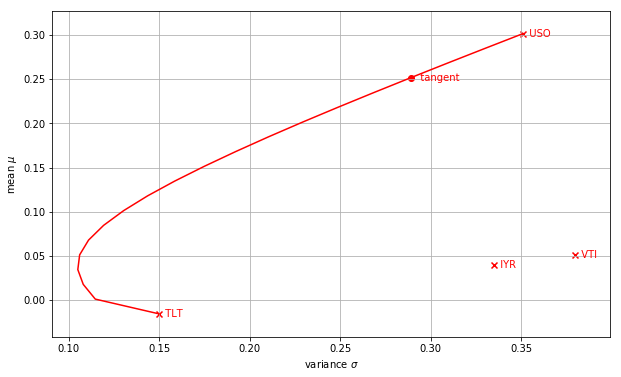

,VTI,TLT,IYR,USO
Weight,3.209238e-17,0.15706,0.0,0.84294


In [55]:
views = views_abs + views_rel
print(views)

res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, color='red')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), show()
display(pd.DataFrame({'Weight': res1.W}, index=names).T)

#display(pd.DataFrame(C, columns=names, index=names))

#### Process - Calculate Efficient Frontier and the Tangent Portfolio based on Equilibrium Returns

In [56]:
# Calculate portfolio historical return and variance
mean, var = port_mean_var(W, R, C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = dot(dot(lmb, C), W)  # Calculate equilibrium excess returns

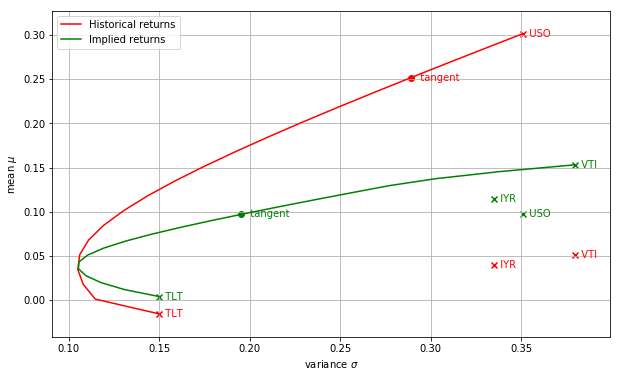

,VTI,TLT,IYR,USO
Weight,0.349693,0.250417,0.199902,0.199988


In [57]:
res2 = optimize_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)

#### Process - Create Views and Link Matrix for the Minimum values input

In [62]:
display(pd.DataFrame(views))

Q, P = create_views_and_link_matrix_min(names, views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
display(pd.DataFrame(P))


tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)

# Calculate equilibrium excess returns with views incorporated
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_adj_min = dot(inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi_adj_min + rf, C, rf)

display(pd.DataFrame({'Weight': res3.W}, index=names).T)


,0,1,2,3,4
0,IYR,=,NA,5.0,7.0
1,VTI,=,NA,5.0,9.0
2,USO,=,NA,10.0,14.0
3,VTI,>,TLT,2.0,4.0
4,USO,>,IYR,2.0,3.0


Views Matrix


,Views
0,5.0
1,5.0
2,10.0
3,2.0
4,2.0


Link Matrix


,0,1,2,3
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,1.0


,VTI,TLT,IYR,USO
Weight,0.25,0.25,0.25,0.25


Views Matrix


,Views
0,5.0
1,5.0
2,10.0
3,2.0
4,2.0


Link Matrix


,0,1,2,3
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,1.0


Views Matrix


,Views
0,7.0
1,9.0
2,14.0
3,4.0
4,3.0


Link Matrix


,0,1,2,3
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,1.0


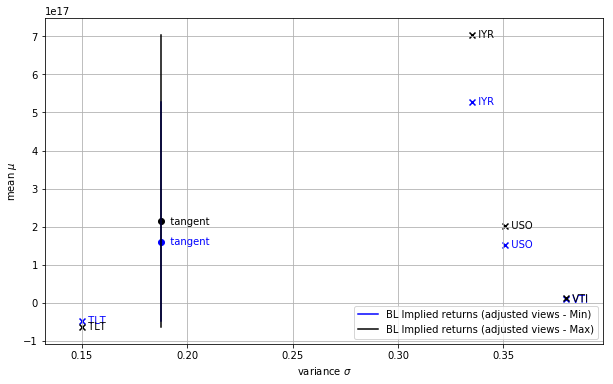

,VTI,TLT,IYR,USO
Weight,0.25,0.25,0.25,0.25


,VTI,TLT,IYR,USO
Weight,0.25,0.25,0.25,0.25


In [58]:
Q, P = create_views_and_link_matrix_min(names, views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
display(pd.DataFrame(P))


tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)

# Calculate equilibrium excess returns with views incorporated
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_adj_min = dot(inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi_adj_min + rf, C, rf)


In [46]:
Q, P = create_views_and_link_matrix_min(names, views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
display(pd.DataFrame(P))



Views Matrix


,Views
0,5.0
1,5.0
2,30.0
3,2.0
4,10.0


Link Matrix


,0,1,2,3
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,1.0


#### Process - Compute BL Portfolio for the Minimum input

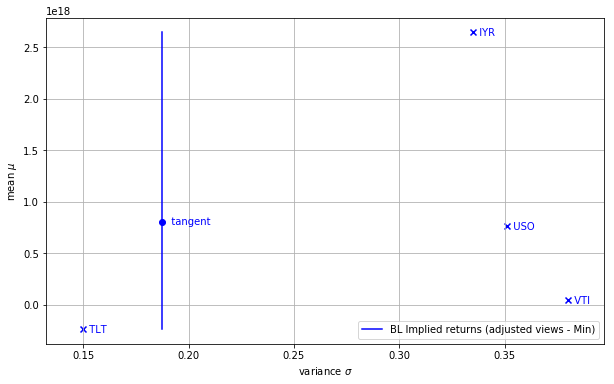

,VTI,TLT,IYR,USO
Weight,0.25,0.25,0.25,0.25


In [47]:
tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)

# Calculate equilibrium excess returns with views incorporated
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_adj = dot(inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi_adj + rf, C, rf)


display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='BL Implied returns (adjusted views - Min)', color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pd.DataFrame({'Weight': res3.W}, index=names).T)


### References

https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model
https://en.wikipedia.org/wiki/Monte_Carlo_method
http://www.quantandfinancial.com/2013/08/black-litterman.html
